In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm
import glob
import math
import random
import inspect
import os.path as osp
from pathlib import Path
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data,Dataset
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv
import h5py

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../DarkFlow/darkflow/')))
import DarkFlow.darkflow.networks.flows as flows

import models_torch.models as models
reload(models)
import models_torch.losses as losses
reload(losses)
import utils_torch.scaler
reload(utils_torch.scaler)
import utils_torch.preprocessing as prepr
import utils_torch.plot_util as plot
reload(plot)
import utils_torch.train_util as train
reload(train)
import graph_data.graph_data as graph_data
reload(graph_data)
import utils_torch.model_summary as summary
reload(summary)




<module 'utils_torch.model_summary' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils_torch/model_summary.py'>

In [12]:
data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
dataset = graph_data.GraphDataset(root=data_dir,n_jets=1e5)
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
   
use_generator = False
if use_generator:
    validation_split = 0.2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(dataset_size,split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    print("train subset dim:", len(train_subset))
    print("validation subset dim", len(val_subset))
    dataloaders = {
        'train':  DataLoader(train_subset, batch_size=128, shuffle=True),
        'val':   DataLoader(val_subset, batch_size=128, shuffle=True)
    }
    print("train_dataloader dim:", len(dataloaders['train']))
    print("val dataloader dim:", len(dataloaders['val']))
else : 
    in_memory_datas = dataset.return_inmemory_data_no_loop() 
   # in_memory_datas = dataset.return_inmemory_data() 

In [4]:
pf_cands,jet_prop = dataset.pf_cands,dataset.jet_prop
pf_cands_t = torch.cat([torch.tensor(pf_cands[i], dtype=torch.float) for i in range(len(pf_cands))])
#Plot consistuents and jet features prepared for the graph! (but before any normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
jet_feats = 'N_constituents,M,Pt,Eta,Phi'.split(',')


save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
vande_plot.plot_features(pf_cands_t.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)
vande_plot.plot_features(jet_prop[:,0:-1], jet_feats ,'Normalized' , 'QCD', plotname='{}plot_jet_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [13]:
len(in_memory_datas)

200000

In [23]:
t.shape

(400000,)

In [17]:
#scaler = standardize(train_subset) # I dont think that this works for the dataset implementation as it is done now, implement scaler as part of dataset ? 
scaler = prepr.standardize(in_memory_datas,minmax_idx=[3,4],log_idx=[3,4]) 

dataloaders = {
    'train':  DataLoader(in_memory_datas, batch_size=128, shuffle=True)
    }
print("train_dataloader dim:", len(dataloaders['train']))

#dataset.get(0).u

train_dataloader dim: 1563


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
pf_cands_norm = torch.cat([torch.tensor(in_memory_datas[i].x, dtype=torch.float) for i in range(len(in_memory_datas))])
#Plot consistuents and jet features prepared for the graph! (after normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats_normalized/'
vande_plot.plot_features(pf_cands_norm.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [14]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = False #torch.cuda.device_count()>1

In [15]:
# model
input_dim = 7
output_dim = 4#7#4#4,7
big_dim = 32
hidden_dim = 2
#model = models.EdgeNet(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
#model = models.EdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
model = models.PlanarEdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

model.to(device)
print(model)
summary.gnn_model_summary(model)

PlanarEdgeNetVAE(
  (mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (var_layer): Linear(in_features=32, out_features=2, bias=True)
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  ))
  (amor_u): Linear(in_features=32, out_features=12, bias=True)
  (amor_w): Linear(in_features=32, out_features=12, bias=True)
  (amor_b): Linear(in_features=32, out_features=6, bias=True)
  (flow_0): Planar(
    (h): Tanh()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (flow_1): Planar(
    (h): Tanh()
  

In [ ]:
#loss
#loss_ftn_obj = losses.LossFunction('mse_coordinates', device=device)
#loss_ftn_obj = losses.LossFunction('mse', device=device)
#loss_ftn_obj = losses.LossFunction('vae_loss_mse',beta=0.00001,device=device)
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.5,device=device)

# Training loop
n_epochs = 80
stale_epochs = 0
loss = 999999
#train_losses = []
for epoch in range(0, n_epochs):
    #loss = train(model, optimizer, loader, len(datas), 128, loss_ftn_obj)
    loss_tot,loss_reco,loss_kl = train.train(model, optimizer, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
    #train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss Tot, Reco, KL :  {:.4f},{:.4f}, {:.4f}'.format(epoch, loss_tot,loss_reco,loss_kl))

train loss tot = 0.1156636,train loss reco = 0.2177279,train loss kl = 0.0135993:   7%|███▏                                             | 103/1562.5 [01:47<24:36,  1.01s/it]

In [20]:
reload(utils_torch.scaler)
reload(prepr)
reload(plot)

save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
inverse_standardization = True
#plot.plot_reco_for_loader(model, dataloaders['train'], device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_100k'), 'all_mseconv')
plot.plot_reco_for_loader(model,test_loader, device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_100k'), 'all_mseconv')


In [8]:
latent = plot.gen_latent(model, dataloaders['train'], device)


In [9]:
mu_fts,log_var_fts,z_0_fts,z_last_fts = latent

In [18]:
#!{sys.executable} -m pip install seaborn
#import seaborn as sns
len(in_memory_datas)

100000

In [19]:
test_loader = DataLoader(in_memory_datas[0:10000], batch_size=128, shuffle=True)


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


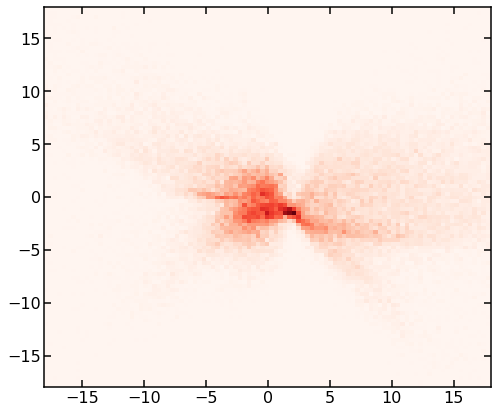

In [11]:
bins = np.linspace(-18,18,100)
plt.hist2d(z_last_fts[:,0].numpy(), y=z_last_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

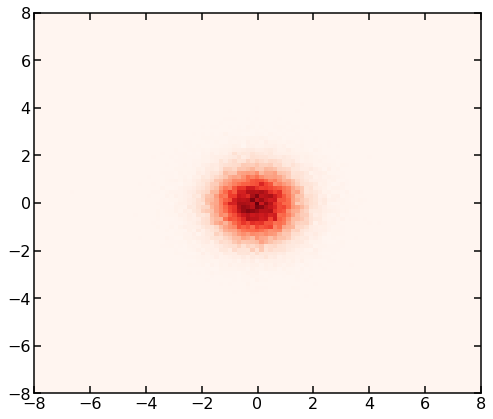

In [12]:
bins = np.linspace(-8,8,100)
plt.hist2d(z_0_fts[:,0].numpy(), y=z_0_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

In [13]:
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.00001,device=device)

loss_tot,loss_reco,loss_kl = train.test(model, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)

valid loss tot = 0.2198390,valid loss reco = 0.2198410,valid loss kl = 0.0202341: : 8it [00:00, 78.56it/s]                  


In [172]:
for data in dataloaders['train']:
    print(data.edge_index.shape)
    break

torch.Size([2, 389804])


In [9]:
test_loader =  DataLoader(in_memory_datas, batch_size=1, shuffle=True)

In [10]:
jets_losses = []
jets_losses_mse = []
jets_losses_kl = []
for k, data_batch in enumerate(test_loader):
    data_batch.to(device)
    jets_x = data_batch.x
    batch = data_batch.batch
    jets_rec, mu,log_var,_,_,_ = model(data_batch)
    njets = len(torch.unique(batch))
    losses = torch.zeros((njets), dtype=torch.float32)
    losses_mse = torch.zeros((njets), dtype=torch.float32)
    losses_kl = torch.zeros((njets), dtype=torch.float32)
    for ib in torch.unique(batch):
        losses[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[0]
        losses_mse[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[1]
        losses_kl[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[2]
    jets_losses.append(losses)
    jets_losses_mse.append(losses_mse)
    jets_losses_kl.append(losses_kl)

In [11]:
jets_losses = np.array([jets_losses[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_mse = np.array([jets_losses_mse[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_kl = np.array([jets_losses_kl[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)

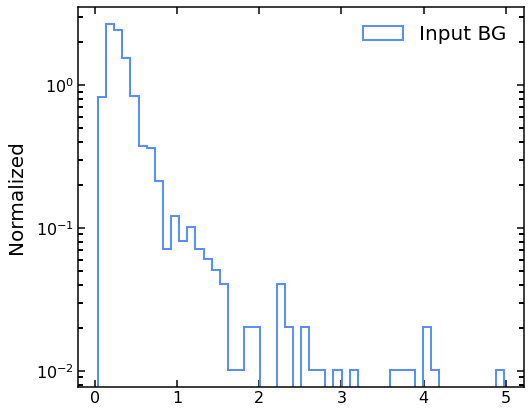

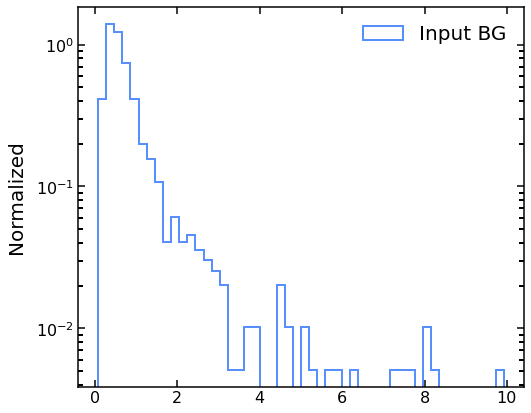

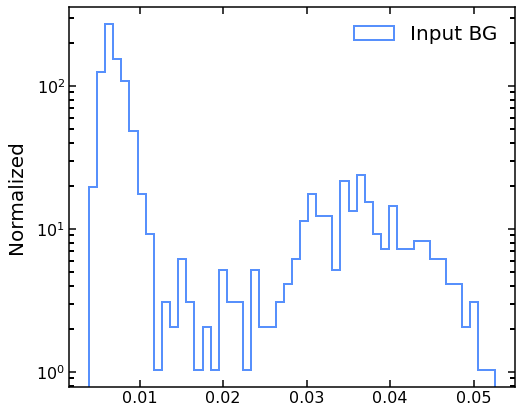

In [33]:
for loss in [jets_losses,jets_losses_mse,jets_losses_kl]:
    xmin = np.quantile(loss,0.05)
    xmax = np.quantile(loss,0.98)
    plt.figure()
    plt.hist(loss, bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [48]:
edge_index_s = torch.tensor([
     [0, 0, 0, 0],
     [1, 2, 3, 4],
 ])
x_s = torch.randn(5, 16)  # 5 nodes.
edge_index_t = torch.tensor([
     [0, 0, 0],
     [1, 2, 3],
])
x_t = torch.randn(4, 16)  # 4 nodes.

data = graph_data.PairJetsData(edge_index_s, x_s, edge_index_t, x_t)
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

In [64]:
loader = DataLoader(data_list, batch_size=1, follow_batch=['x_1', 'x_2'])
batch = next(iter(loader))

In [65]:
next(iter(loader))

Batch(edge_index_1=[2, 4], edge_index_2=[2, 3], x_1=[5, 16], x_1_batch=[5], x_2=[4, 16], x_2_batch=[4])

In [67]:
len(in_memory_datas[0])

3

In [115]:
jet_pair_1 = graph_data.PairJetsData(in_memory_datas[0].edge_index, in_memory_datas[0].x, in_memory_datas[1].edge_index, in_memory_datas[1].x)
jet_pair_2 = graph_data.PairJetsData(in_memory_datas[2].edge_index, in_memory_datas[2].x, in_memory_datas[3].edge_index, in_memory_datas[3].x)
jet_pair = [jet_pair_1,jet_pair_2,jet_pair_2,jet_pair_2,jet_pair_2,jet_pair_2]


In [157]:
jet_pair_loader = DataLoader(jet_pair, batch_size=2, shuffle=False,follow_batch=['x_1', 'x_2'])
jet_pair_loader_all = DataLoader(jet_pair, batch_size=2, shuffle=False)


In [156]:
next(iter(jet_pair_loader))

Batch(edge_index_1=[2, 4722], edge_index_2=[2, 5314], x_1=[98, 7], x_1_batch=[98], x_2=[103, 7], x_2_batch=[103])

In [162]:
next(iter(jet_pair_loader_all))

Batch(edge_index_1=[2, 4722], edge_index_2=[2, 5314], x_1=[98, 7], x_2=[103, 7])

In [109]:
test_load = DataLoader(in_memory_datas, batch_size=2, shuffle=True)


Batch(batch=[106], edge_index=[2, 5544], ptr=[3], u=[2, 6], x=[106, 7])

In [93]:
def return_jets_pair_data(in_memory_datas):    
    datas = [graph_data.PairJetsData(in_memory_datas[i_evt].edge_index, in_memory_datas[i_evt].x, in_memory_datas[i_evt+1].edge_index, in_memory_datas[i_evt+1].x) for i_evt in range(0,1000,2)]
    return datas

In [95]:
in_memory_jets = return_jets_pair_data(in_memory_datas) 

In [96]:
in_memory_jets

[PairJetsData(edge_index_1=[2, 2070], edge_index_2=[2, 1892], x_1=[46, 7], x_2=[44, 7]),
 PairJetsData(edge_index_1=[2, 2652], edge_index_2=[2, 3422], x_1=[52, 7], x_2=[59, 7]),
 PairJetsData(edge_index_1=[2, 2550], edge_index_2=[2, 600], x_1=[51, 7], x_2=[25, 7]),
 PairJetsData(edge_index_1=[2, 7656], edge_index_2=[2, 9312], x_1=[88, 7], x_2=[97, 7]),
 PairJetsData(edge_index_1=[2, 240], edge_index_2=[2, 2862], x_1=[16, 7], x_2=[54, 7]),
 PairJetsData(edge_index_1=[2, 552], edge_index_2=[2, 1560], x_1=[24, 7], x_2=[40, 7]),
 PairJetsData(edge_index_1=[2, 3422], edge_index_2=[2, 5112], x_1=[59, 7], x_2=[72, 7]),
 PairJetsData(edge_index_1=[2, 2256], edge_index_2=[2, 2862], x_1=[48, 7], x_2=[54, 7]),
 PairJetsData(edge_index_1=[2, 1892], edge_index_2=[2, 552], x_1=[44, 7], x_2=[24, 7]),
 PairJetsData(edge_index_1=[2, 992], edge_index_2=[2, 3906], x_1=[32, 7], x_2=[63, 7]),
 PairJetsData(edge_index_1=[2, 2070], edge_index_2=[2, 1980], x_1=[46, 7], x_2=[45, 7]),
 PairJetsData(edge_index_1

In [106]:
for data_batch in dataloaders['train']:
    batch = data_batch.batch
    #print(torch.unique(batch))
    for ib in torch.unique(batch):
        print(len(data_batch.x[batch==ib]))
        print(ib)
    break

44
tensor(0)
49
tensor(1)
32
tensor(2)
65
tensor(3)
50
tensor(4)
34
tensor(5)
33
tensor(6)
45
tensor(7)
42
tensor(8)
43
tensor(9)
82
tensor(10)
73
tensor(11)
60
tensor(12)
72
tensor(13)
100
tensor(14)
38
tensor(15)
46
tensor(16)
58
tensor(17)
78
tensor(18)
61
tensor(19)
47
tensor(20)
22
tensor(21)
40
tensor(22)
27
tensor(23)
43
tensor(24)
53
tensor(25)
42
tensor(26)
43
tensor(27)
38
tensor(28)
46
tensor(29)
47
tensor(30)
36
tensor(31)
28
tensor(32)
23
tensor(33)
35
tensor(34)
39
tensor(35)
68
tensor(36)
100
tensor(37)
30
tensor(38)
32
tensor(39)
35
tensor(40)
41
tensor(41)
58
tensor(42)
46
tensor(43)
49
tensor(44)
39
tensor(45)
46
tensor(46)
88
tensor(47)
29
tensor(48)
51
tensor(49)
53
tensor(50)
53
tensor(51)
50
tensor(52)
51
tensor(53)
56
tensor(54)
47
tensor(55)
61
tensor(56)
49
tensor(57)
45
tensor(58)
57
tensor(59)
72
tensor(60)
55
tensor(61)
54
tensor(62)
41
tensor(63)
32
tensor(64)
52
tensor(65)
26
tensor(66)
62
tensor(67)
53
tensor(68)
54
tensor(69)
33
tensor(70)
69
tensor(71)


In [154]:
for data_batch in jet_pair_loader:
    batch_x1 = data_batch.x_1_batch
    batch_x2 = data_batch.x_2_batch
    print(torch.unique(batch_x1),torch.unique(batch_x2))
    print('next batch of 2')
    for i,ib in enumerate(torch.unique(batch_x1)):
        print('ib = ',ib)
        print(len(data_batch.x_1[batch_x1==ib]))
        print(len(data_batch.x_2[batch_x2==ib]))


tensor([0, 1]) tensor([0, 1])
next batch of 2
ib =  tensor(0)
46
44
ib =  tensor(1)
52
59
tensor([0, 1]) tensor([0, 1])
next batch of 2
ib =  tensor(0)
52
59
ib =  tensor(1)
52
59
tensor([0, 1]) tensor([0, 1])
next batch of 2
ib =  tensor(0)
52
59
ib =  tensor(1)
52
59


In [4]:
import networkx as nx


In [ ]:
x = np.arange(0, n_parts)
x = x[:, None] - x[:, None]*np.eye(n_parts)


In [168]:
pf_cands = dataset.pf_cands
for i_evt in range(1): #the way it is written now it is only taking a leading jet
    n_particles = pf_cands[i_evt].shape[0]
    pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles),range(n_particles)) if m!=n])
    edge_index = torch.tensor(pairs, dtype=torch.long)
    print(edge_index)
    edge_index=edge_index.t().contiguous()
    print(edge_index)

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        ...,
        [45, 42],
        [45, 43],
        [45, 44]])
tensor([[ 0,  0,  0,  ..., 45, 45, 45],
        [ 1,  2,  3,  ..., 42, 43, 44]])


In [167]:
edge_index


tensor([[ 0,  0,  0,  ..., 45, 45, 45],
        [ 1,  2,  3,  ..., 42, 43, 44]])

In [18]:
x = np.arange(0, n_particles)
#x = x[:, None] - x[:, None]*np.eye(n_particles)
#x = x - x*np.eye(n_particles)


In [32]:
x = np.array([[1,2],[3,4]])
np.repeat(x, 3, axis=1)

array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])

In [133]:
x = np.arange(0, n_particles)
x = np.repeat(x,n_particles-1)

In [134]:
y = np.arange(0, n_particles-1)
#y = np.tile(y+1,n_particles)
y

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [137]:
y.repeat(2)

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
       17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25,
       25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33,
       34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42,
       42, 43, 43, 44, 44])

In [77]:
edge_index[1][0:46*3]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45,  0,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45,  0,  1,  2])

In [106]:
y = np.arange(0, n_particles)


In [117]:
np.eye(n_particles-1).reshape(-1)[45:45*2]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
adj = torch.Tensor(np.eye(n_particles))
edge_index = (adj > 0).nonzero().t()
row, col = edge_index
edge_weight = adj[row, col]


In [154]:
edges = adj.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
#node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
edge_indices_row = edges[:,0] * 45 + edges[:,0]
edge_indices_col = edges[:,0] * 45 + edges[:,1]

In [155]:
edge_indices_col

tensor([   0,   46,   92,  138,  184,  230,  276,  322,  368,  414,  460,  506,
         552,  598,  644,  690,  736,  782,  828,  874,  920,  966, 1012, 1058,
        1104, 1150, 1196, 1242, 1288, 1334, 1380, 1426, 1472, 1518, 1564, 1610,
        1656, 1702, 1748, 1794, 1840, 1886, 1932, 1978, 2024, 2070])

In [156]:
edge_indices_row

tensor([   0,   46,   92,  138,  184,  230,  276,  322,  368,  414,  460,  506,
         552,  598,  644,  690,  736,  782,  828,  874,  920,  966, 1012, 1058,
        1104, 1150, 1196, 1242, 1288, 1334, 1380, 1426, 1472, 1518, 1564, 1610,
        1656, 1702, 1748, 1794, 1840, 1886, 1932, 1978, 2024, 2070])

In [174]:
import torch_geometric
import scipy
edge_index,_ = torch_geometric.utils.from_scipy_sparse_matrix(scipy.sparse.eye(n_particles))

In [176]:
edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45]])

In [177]:
real_p_mask = particles[:,:,0] > 0 # construct mask for real particles
adjacencies = (real_p_mask[:,:,np.newaxis] * real_p_mask[:,np.newaxis,:]).astype('float32')

<46x46 sparse matrix of type '<class 'numpy.float64'>'
	with 46 stored elements (1 diagonals) in DIAgonal format>

In [194]:
y = np.arange(0, n_particles)
adjacencies = (y[:,np.newaxis] * y[np.newaxis,:]).astype('int32')

In [195]:
if 1>0:
        DATA_PATH = '/eos/cms/store/group/phys_b2g/CASE/h5_files/full_run2/BB_UL_MC_small_v2/'
        TRAIN_NAME = 'BB_batch0.h5'
        filename_bg = DATA_PATH + TRAIN_NAME 
        in_file = h5py.File(filename_bg, 'r') 
        jet_kin = np.array(in_file["jet_kinematics"])
        truth = np.array(in_file["truth_label"])

        j1Pt_mask = (jet_kin[:,self.jet_kin_names.index('j1Pt')] > self.jPt)
        j2Pt_mask = (jet_kin[:,self.jet_kin_names.index('j2Pt')] > self.jPt)
        proc_mask = eval('truth[:,0]{}'.format(self.proc_type))
        full_mask = j1Pt_mask & j2Pt_mask & proc_mask
        if self.side_reg : 
            full_mask = full_mask & (jet_kin[:,self.jet_kin_names.index('DeltaEtaJJ')] > self.dEtaJJ)
        else : 
            full_mask = full_mask & (jet_kin[:,self.jet_kin_names.index('DeltaEtaJJ')] < self.dEtaJJ)

        #Apply mask on jet kinematics, truth and pf cands
        jet_kin = jet_kin[full_mask][0:self.n_jets]
        truth = truth[full_mask][0:self.n_jets]
        jet_const = [np.array(in_file["jet1_PFCands"])[full_mask][0:self.n_jets],np.array(in_file["jet2_PFCands"])[full_mask][0:self.n_jets]]
        ###############                

        pf_out_list = []
        jet_prop_list = []

        for i_j in range(2): #each event has 2 jets # in principle probably good to check and discard this event otherwise
            pf_xyze = jet_const[i_j]
            pf_ptep = self.xyze_to_ptep(pf_xyze)
            n_particles = np.sum(pf_xyze[:,:,self.pf_kin_names.index('E')]!=0,axis=1) #E is 3rd 
            pf_xyze_out = list(map(get_present_constit,pf_xyze,n_particles))
            pf_ptep_out = list(map(get_present_constit,pf_ptep,n_particles))
            pf_tot_out = list(map(concat_features,pf_xyze_out,pf_ptep_out))
            pf_out_list.append(pf_tot_out)

            n_jet_feats = 6
            jet_prop = np.zeros((len(pf_tot_out),n_jet_feats))
            jet_prop[:,0] = n_particles
            for i_f,f_name in enumerate('M,Pt,Eta,Phi'.split(',')):
                jet_prop[:,i_f+1] = jet_kin[:,self.jet_kin_names.index('j{}{}'.format(i_j+1,f_name))]
            jet_prop[:,n_jet_feats-1] = truth[:,0]
            jet_prop_list.append(jet_prop)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [13]:
DATA_PATH = '/eos/cms/store/group/phys_b2g/CASE/h5_files/full_run2/BB_UL_MC_small_v2/'
TRAIN_NAME = 'BB_batch0.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
jet_kin = np.array(in_file["jet_kinematics"])
truth = np.array(in_file["truth_label"])

In [26]:
pf = in_file['jet1_PFCands'][:100]

NameError: name 'in_file' is not defined

In [22]:
ak_array = ak.from_numpy(in_file['jet1_PFCands'])

In [45]:
ak_array[ak_array[:,:,3]>0][0,:]

<Array [63.6, 169, -472, 506] type='4 * float16'>

In [46]:
ak_array[0,:]

<Array [[63.6, 169, -472, 506, ... 0, 0, 0, 0]] type='100 * 4 * float16'>

In [25]:
n_particles = [5,4]
np.ones((n_particles,n_particles)) - np.eye(n_particles)

TypeError: 'list' object cannot be interpreted as an integer

In [5]:
pf_cands[:100][0].shape

NameError: name 'pf_cands' is not defined

In [50]:
c = pf_cands[:100] + pf_cands[100:200]
c[::2] = pf_cands[:100]
c[1::2] = pf_cands[100:200]

In [41]:
len(pf_cands)

200000

In [52]:
print(c[0][0,:])
print(c[1][0,:])

[  63.59375    168.625     -472.25       505.5        180.21808
   -1.6910543    1.2101585]
[-1.9262500e+02  2.9140625e+00  5.5390625e+00  1.9275000e+02
  1.9264705e+02  2.8748427e-02  3.1264656e+00]


In [49]:
pf_cands[:100]

[array([[ 6.35937500e+01,  1.68625000e+02, -4.72250000e+02,
          5.05500000e+02,  1.80218079e+02, -1.69105434e+00,
          1.21015847e+00],
        [ 2.70000000e+01,  6.95000000e+01, -1.96750000e+02,
          2.10500000e+02,  7.45603790e+01, -1.69758201e+00,
          1.20025229e+00],
        [ 1.98125000e+01,  5.42187500e+01, -1.53125000e+02,
          1.63625000e+02,  5.77252808e+01, -1.70247877e+00,
          1.22045279e+00],
        [ 9.64062500e+00,  2.68750000e+01, -7.08750000e+01,
          7.64375000e+01,  2.85518341e+01, -1.64064765e+00,
          1.22637355e+00],
        [ 8.07031250e+00,  2.08437500e+01, -5.62812500e+01,
          6.05312500e+01,  2.23515511e+01, -1.65389633e+00,
          1.20138907e+00],
        [ 7.54296875e+00,  1.62656250e+01, -4.60000000e+01,
          4.93750000e+01,  1.79294987e+01, -1.67132413e+00,
          1.13657784e+00],
        [ 7.85937500e+00,  1.60000000e+01, -4.53750000e+01,
          4.87500000e+01,  1.78260975e+01, -1.66397083e+00

In [54]:
import itertools

c = list(itertools.chain(*zip(pf_cands[:100] , pf_cands[100:200])))

In [56]:
print(c[0][0,:])
print(c[1][0,:])

[  63.59375    168.625     -472.25       505.5        180.21808
   -1.6910543    1.2101585]
[-100.5        -13.2265625  159.125      188.75       101.36662
    1.2328662   -3.0107372]
